# Importing ressources

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.svm import SVR
from collections import Counter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

# sklearn part
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# other models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# others
from scipy.stats import uniform, randint

In [2]:
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

df_new_bs_features_train = pd.read_csv('data/new_bs_features_train.csv')
df_new_bs_features_test = pd.read_csv('data/new_bs_features_test.csv')




In [3]:
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

In [4]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

**FIXING SEED**

In [5]:
SEED = 42

# Pipeline

### Notes :
- Features plaace hierarchy lv1/lv2 not useful
- grunnkret ID important
- robust scaler not useful here
- encoding on the df_all is better than indivudal (fit + transform)
- scaling the data with the fit of just train is better to prevent leak (fit + transform) 
- Need to clean the pipeline

In [6]:
def label_uniformier(array_train, array_test):
    """
    Take the unique values from the train and test part to combine it in a single array.
    Useful to fit the label encoder and don't do a mess during the transform (previously fit_transform that was confusing)
    """
    label_encoder = LabelEncoder()
    labels = np.asarray(list(array_train.unique()) + list(set(array_test.unique()) - set(array_train.unique())))
    label_encoder.fit(labels)
    return label_encoder

In [7]:
def create_population_age():
    df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
    df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
#     df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
#     df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
#     df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)
    return df_grunnkrets_population

In [8]:
def create_population_repartition():
    return df_grunnkrets_house_pers[['grunnkrets_id', 'couple_children_0_to_5_years', 'couple_children_6_to_17_years', 'couple_children_18_or_above', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_6_to_17_years', 'single_parent_children_18_or_above', 'singles']]

In [9]:
def create_income_repartition():
    return df_grunnkrets_income_house[['grunnkrets_id', 'all_households']]

In [10]:
def create_grunnkret_geodata():
    return df_grunnkrets_stripped[['grunnkrets_id', 'area_km2', 'municipality_name']]

In [11]:
def create_hierarchy():
    return df_plaace_hierarchy[['plaace_hierarchy_id', 'lv3_desc']]

In [12]:
def fix_municipalities(current_df):
    # Get the rows with missing municipality
    df_missing_mun = current_df[current_df["municipality_name"].isna()]
    # Create a copy of the current df and drop row where mun = NaN + Reset index
    current_df_copy = current_df.copy().dropna(subset=['municipality_name'])
    current_df_copy = current_df_copy.reset_index(drop=True)
    # For each missing municipality
    for index, row in df_missing_mun.iterrows():
        # Create a df with the the difference with the loc of the current store and all the others stores
        tmp_df = pd.concat([current_df_copy.loc[:, ["lat"]] - row.lat, current_df_copy.loc[:, ["lon"]] - row.lon], axis=1)
        # Find the idx of the one with the smallest error (the closest from the other)
        idx = np.argmin(np.linalg.norm(tmp_df.to_numpy(), axis=1))
        # Retrieve the municipality of the closest one and input it in the missing one
        current_df.loc[index, "municipality_name"] = current_df_copy.loc[idx, "municipality_name"]
    return current_df

In [13]:
#train

df_train = df_train.drop(df_train[df_train.revenue <= df_train.revenue.quantile(.03)].index)
df_train = df_train.drop(df_train[df_train.revenue >= df_train.revenue.quantile(1 - .03)].index)


X_train = df_train.loc[:, ['store_id', 'grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id']]

X_test = df_test.loc[:, ['store_id', 'grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id']]

X_train['lat'] = X_train.lat * 11.112
X_train['lon'] = X_train.lon * 6.4757
X_test['lat'] = X_test.lat * 11.112
X_test['lon'] = X_test.lon * 6.4757

# Area & Municipality
X_train = pd.merge(X_train, create_grunnkret_geodata(), how="left", on="grunnkrets_id")
X_test = pd.merge(X_test, create_grunnkret_geodata(), how="left", on="grunnkrets_id")

# Plaace Hierarchy
X_train = pd.merge(X_train, create_hierarchy(), how='left', on='plaace_hierarchy_id')
X_test = pd.merge(X_test, create_hierarchy(), how='left', on='plaace_hierarchy_id')

# Population
X_train = pd.merge(X_train, create_population_age(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_population_age(), how='left', on='grunnkrets_id')
# Population density
X_train["population_density"] = X_train["total_population"] / X_train["area_km2"]
X_test["population_density"] = X_test["total_population"] / X_test["area_km2"]

# Income
X_train = pd.merge(X_train, create_income_repartition(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_income_repartition(), how='left', on='grunnkrets_id')

# Distance (shop-closest BS & mean BS in 1km radius)
X_train = pd.merge(X_train, df_new_bs_features_train, how='left', on='store_id')
X_test = pd.merge(X_test, df_new_bs_features_test, how='left', on='store_id')


""" ENCODING """
# Sales Channel Name
le = label_uniformier(X_train['sales_channel_name'], X_test['sales_channel_name'])
X_train['encoded_channel_name'] = le.transform(X_train['sales_channel_name'])
X_test['encoded_channel_name'] = le.transform(X_test['sales_channel_name'])

# Mall Name
X_train['mall_name'] = X_train['mall_name'].fillna('0')
X_test['mall_name'] = X_test['mall_name'].fillna('0')
le = label_uniformier(X_train['mall_name'], X_test['mall_name'])
X_train['encoded_mall'] = le.transform(X_train['mall_name'])
X_test['encoded_mall'] = le.transform(X_test['mall_name'])

# Chain Name
X_train['chain_name'] = X_train['chain_name'].fillna('0')
X_test['chain_name'] = X_test['chain_name'].fillna('0')
le = label_uniformier(X_train['chain_name'], X_test['chain_name'])
X_train['encoded_chain'] = le.transform(X_train['chain_name'])
X_test['encoded_chain'] = le.transform(X_test['chain_name'])

# Hierarchy LV3
le = label_uniformier(df_plaace_hierarchy['lv3_desc'], df_plaace_hierarchy['lv3_desc'])
X_train['encoded_lv3'] = le.transform(X_train['lv3_desc'])
X_test['encoded_lv3'] = le.transform(X_test['lv3_desc'])

# Municipality feature
X_train = fix_municipalities(X_train)
X_test = fix_municipalities(X_test)
le = label_uniformier(X_train['municipality_name'], X_test['municipality_name'])
X_train['municipality_encoded'] = le.transform(X_train['municipality_name'])
X_test['municipality_encoded'] = le.transform(X_test['municipality_name'])

""" DROP USELESS """
X_train = X_train.drop(['lat', 'lon', 'store_id', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id', 'lv3_desc', 'total_population', 'area_km2', 'municipality_name'], axis=1)
X_test = X_test.drop(['lat', 'lon', 'store_id', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id', 'lv3_desc', 'total_population', 'area_km2', 'municipality_name'], axis=1)

""" FILLING NAN WITH MEAN """
X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

""" SCALING """
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

Y_train = df_train.loc[:, ['revenue', ]]
Y_train = np.log10(Y_train + 1)
Y_train = scaler.fit_transform(Y_train)

In [14]:
X_train

,grunnkrets_id,population_density,all_households,BS_closest_mangler_viktighetsnivå,BS_mean_1km_mangler_viktighetsnivå,BS_closest_standard_holdeplass,BS_mean_1km_standard_holdeplass,BS_closest_lokalt_knutepunkt,BS_mean_1km_lokalt_knutepunkt,BS_closest_nasjonalt_knutepunkt,BS_mean_1km_nasjonalt_knutepunkt,BS_closest_regionalt_knutepunkt,BS_mean_1km_regionalt_knutepunkt,BS_closest_annen_viktig_holdeplass,BS_mean_1km_annen_viktig_holdeplass,encoded_channel_name,encoded_mall,encoded_chain,encoded_lv3,municipality_encoded
0,-0.579810,-0.250926,-0.763322,0.030297,0.793465,-0.452534,2.038551,-0.500110,1.205438,-0.024656,-0.387699,-0.413719,-0.548323,-0.344590,-0.307480,-0.363719,2.084687,1.741919,-0.439071,-1.409422
1,-1.098818,0.000000,-1.029015,-0.263665,0.156423,-0.136751,-0.732951,-0.558246,0.726875,-0.835100,-0.387699,-0.464953,-0.035245,-0.405309,-0.307480,-0.363719,-0.377974,1.741919,-0.439071,0.323334
2,-0.574672,-0.120913,-1.328058,-0.327491,0.215350,-0.437918,-0.732951,-0.281283,-0.707652,0.106378,-0.387699,-0.401887,-0.548323,-0.417359,-0.307480,-0.363719,1.767463,0.059857,-0.439071,0.459906
3,1.492740,0.143433,-0.815571,0.078509,1.210442,-0.426827,-0.732951,-0.435054,-0.707652,-0.857699,3.493618,-0.467775,0.055026,2.603423,-0.307480,-0.363719,1.166407,0.059857,-0.439071,-1.511851
4,1.143972,0.000000,1.737972,-0.187295,0.086845,-0.519318,1.250981,-0.527031,0.507677,0.669545,-0.387699,1.194384,-0.548323,-0.449740,3.253416,-0.363719,3.562283,0.059857,-0.439071,1.236658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12093,-1.212637,-0.088249,0.307232,-0.227788,-0.600422,-0.303650,-0.732951,-0.491094,1.533402,-0.581887,-0.387699,-0.052871,-0.548323,-0.411121,-0.307480,-1.808746,-0.377974,-0.515585,-2.400415,1.330551
12094,-0.752220,0.011752,-1.949491,-0.105410,0.704423,0.818272,-0.732951,-0.299854,-0.707652,0.085047,-0.387699,-0.342224,-0.548323,-0.352319,-0.307480,-1.808746,0.598742,1.033682,-2.400415,-0.965563
12095,-1.219432,0.544765,-0.301972,-0.257105,0.270911,0.169992,-0.732951,-0.356503,-0.707652,-0.149072,-0.387699,-0.383152,-0.548323,-0.430670,-0.307480,-1.808746,3.403671,1.033682,-2.400415,0.733049
12096,0.282297,0.446975,-0.944526,-0.265359,0.323714,-0.505854,0.863266,0.177875,-0.707652,-0.309738,-0.387699,0.034535,-0.548323,-0.382666,-0.307480,-1.808746,0.523610,-0.515585,-2.400415,0.622085


**Warning**

Only run this for testing part, not for the submission model training

In [121]:
X_train, X_train_test, Y_train, Y_train_test = train_test_split(X_train, Y_train)

# Simple Model


Learning rate set to 0.056
Learning rate set to 0.056
Learning rate set to 0.056
Learning rate set to 0.056001
Learning rate set to 0.056001


/usr/lib/python3/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/lhome/dilettaq/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/lhome/dilettaq/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/lhome/dilettaq/.local/lib/python3.10/site-packages/catboost/core.py", line 1759, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4623, in _cat

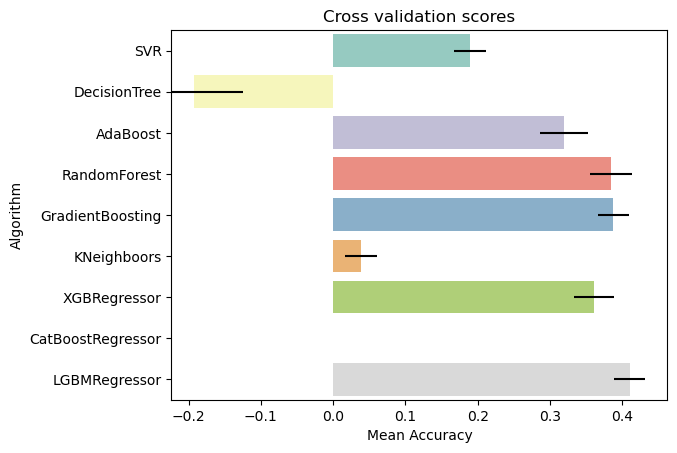

In [123]:
random_state = 2
classifiers = []
classifiers.append(SVR())
classifiers.append(DecisionTreeRegressor(random_state=random_state))
classifiers.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestRegressor(random_state=random_state))
classifiers.append(GradientBoostingRegressor(random_state=random_state))
classifiers.append(KNeighborsRegressor())
classifiers.append(XGBRegressor(random_state=random_state))
classifiers.append(CatBoostRegressor())
classifiers.append(LGBMRegressor(random_state=random_state))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = np.ravel(Y_train), cv = KFold(5), n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVR","DecisionTree","AdaBoost",
"RandomForest","GradientBoosting","KNeighboors","XGBRegressor","CatBoostRegressor","LGBMRegressor"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## HyperParameter tuning for the best model

## LGMBegressor

In [124]:
from scipy.stats import loguniform
import lightgbm as lgb
param_distributions = {
   'learning_rate': [0.05, 0.01, 0.001],
    'num_leaves': [90,200,300,20],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
}
LGB = lgb.LGBMRegressor()
clf_LGB= GridSearchCV(estimator=LGB, 
                   param_grid=param_distributions,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf_LGB.fit(X_train,np.ravel(Y_train))
print("Best parameters:", clf_LGB.best_params_)
print("Lowest RMSE: ", (-clf_LGB.best_score_)**(1/2.0))
lgbBest = clf_LGB.best_estimator_
print(clf_LGB.best_score_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  2.4min finished


Best parameters: {'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 8, 'metric': 'auc', 'min_data_in_leaf': 10, 'min_split_gain': 0.01, 'num_leaves': 200, 'objective': 'binary', 'random_state': 501, 'subsample': 0.5}
Lowest RMSE:  0.9834456845968487
-0.9671654145521644


## GradientBoosting

In [130]:
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingRegressor
param_distributions = {
   'n_estimators':[500,1000,2000],
   'learning_rate':[.001,0.01,.1],
   'max_depth':[1,2,4],
   'subsample':[.5,.75,1],
   'random_state':[1,10,20]
}
gbr = GradientBoostingRegressor()
clf_GBR = RandomizedSearchCV(estimator=gbr, 
            param_distributions=param_distributions,
            scoring="neg_mean_absolute_error",
            n_iter=20,
            random_state=0,
            n_jobs=2,
            verbose=1)
clf_GBR.fit(X_train,np.ravel(Y_train))
print("Best parameters:", clf_GBR.best_params_)
print("Lowest RMSE: ", (-clf_GBR.best_score_)**(1/2.0))
gradientboostBest = clf_GBR.best_estimator_
print(clf_GBR.best_score_)




Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 19.8min finished


Best parameters: {'subsample': 0.75, 'random_state': 10, 'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.01}
Lowest RMSE:  0.7763861639499496
-0.602775475572918


In [ ]:
## Xgbregressor

In [125]:
from scipy.stats import loguniform

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(seed = 20)
clfXGBR = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clfXGBR.fit(X_train,np.ravel(Y_train))
print("Best parameters:", clfXGBR.best_params_)
print("Lowest RMSE: ", (-clfXGBR.best_score_)**(1/2.0))
xgbrbest = clfXGBR.best_estimator_
print(clfXGBR.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  8.2min finished


Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Lowest RMSE:  0.761586313648281
-0.5800137131363778


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

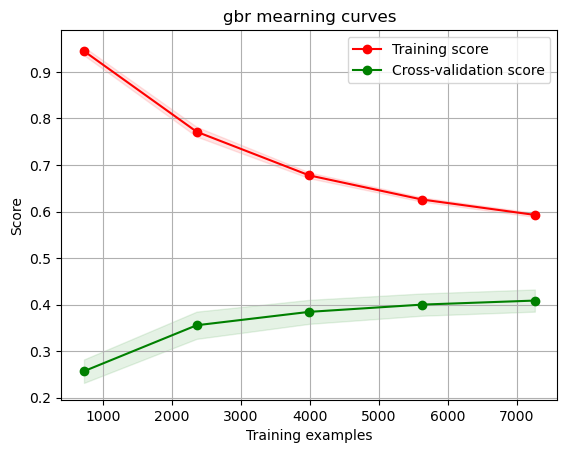

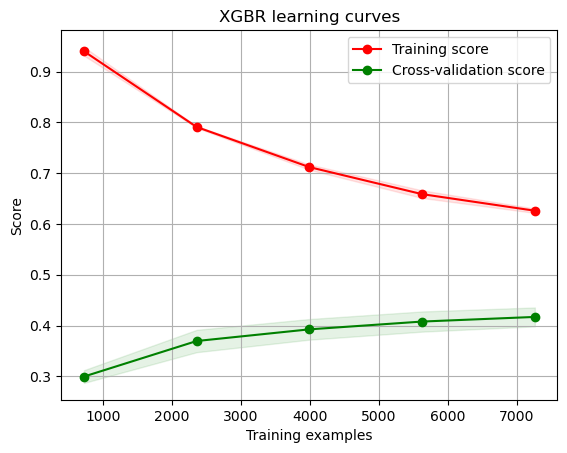

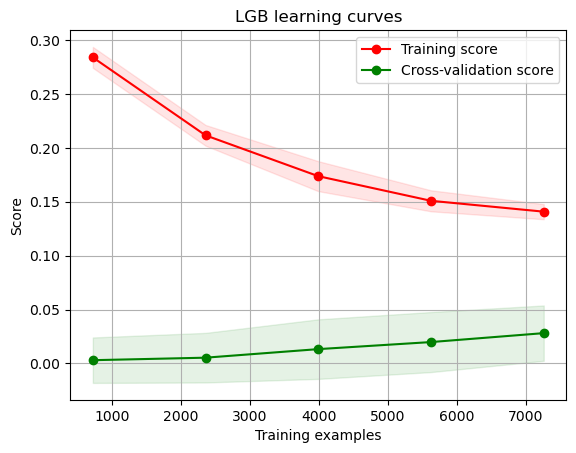

In [132]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(clf_GBR.best_estimator_,"gbr mearning curves",X_train,np.ravel(Y_train),cv=KFold(5))
g = plot_learning_curve(clfXGBR.best_estimator_,"XGBR learning curves",X_train,np.ravel(Y_train),cv=KFold(5))
g = plot_learning_curve(clf_LGB.best_estimator_,"LGB learning curves",X_train,np.ravel(Y_train),cv=KFold(5))
#g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
#g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

IndexError: tuple index out of range

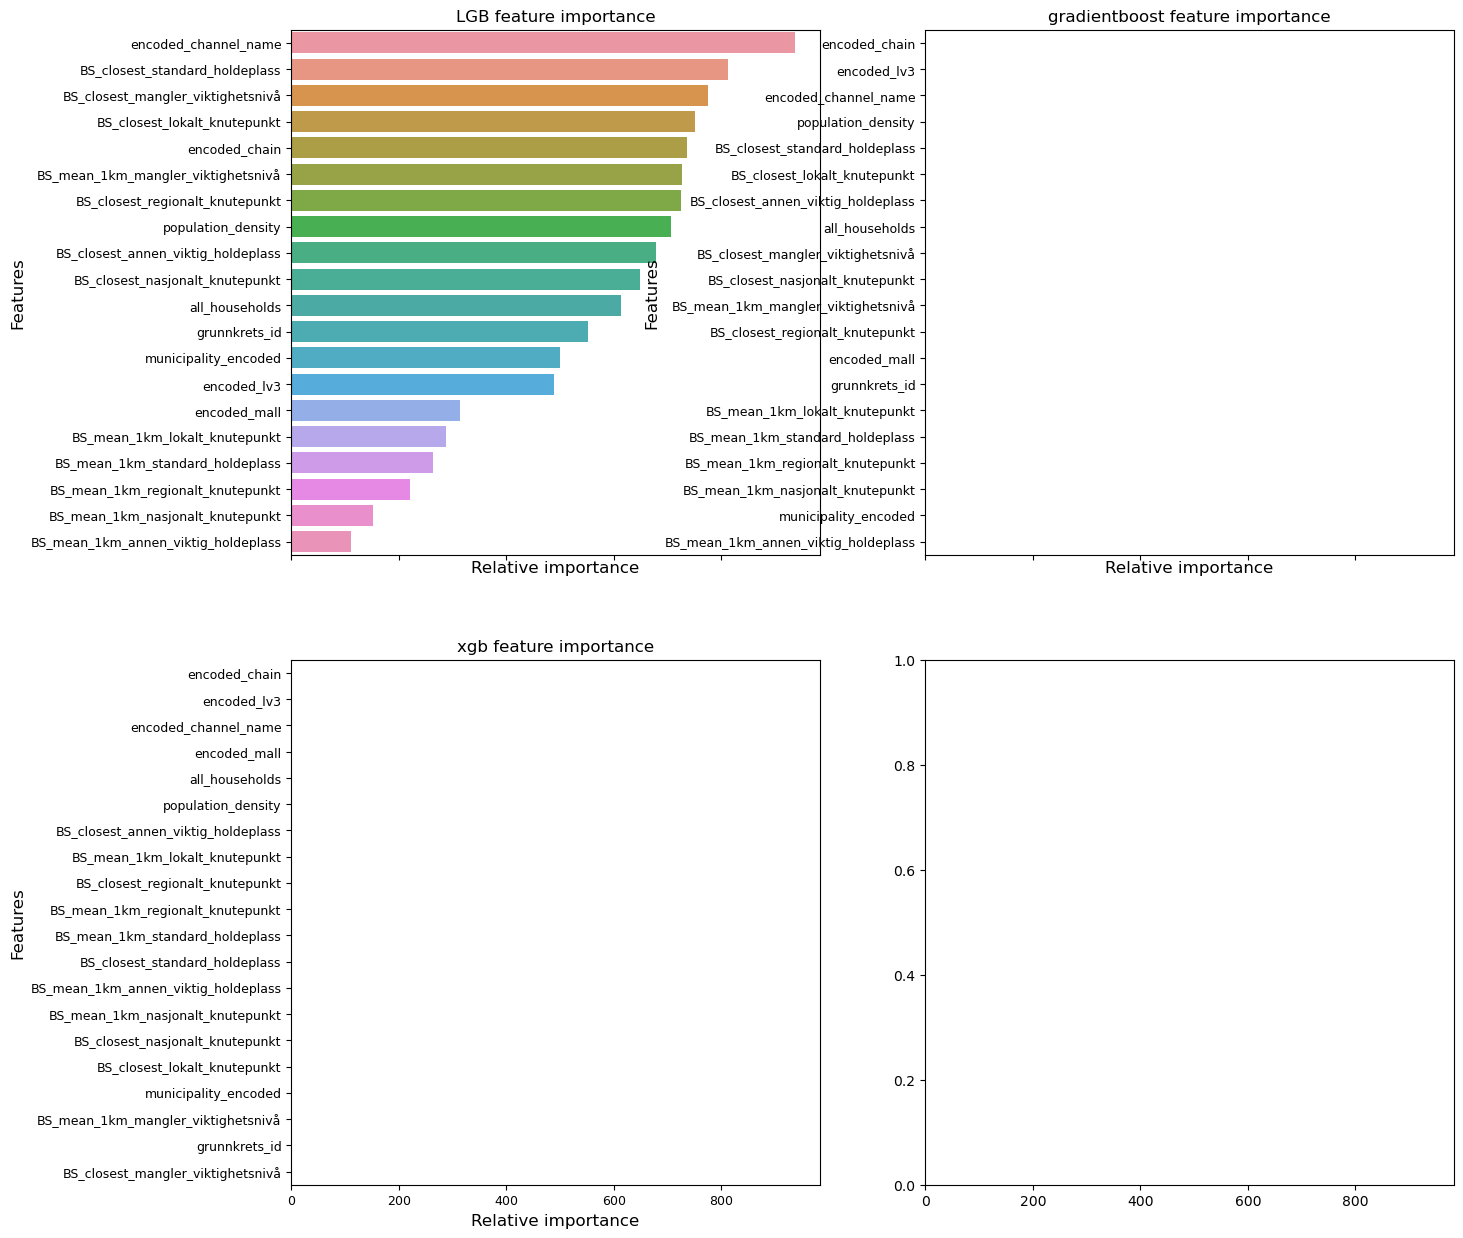

In [140]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("LGB", lgbBest),("gradientboost",gradientboostBest),("xgb",xgbrbest)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:30]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:30] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

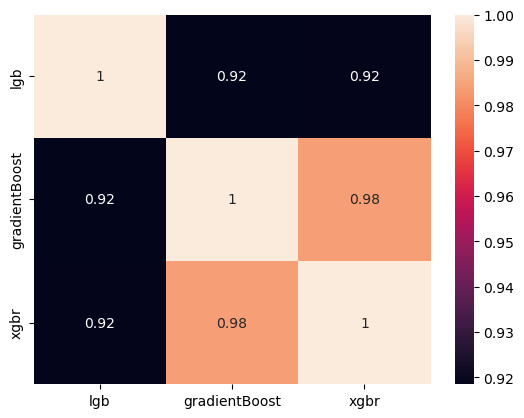

In [141]:
test_Survived_lgb = pd.Series(lgbBest.predict(X_train_test), name="lgb")
test_Survived_gb = pd.Series(gradientboostBest.predict(X_train_test), name="gradientBoost")
test_Survived_xgb= pd.Series(xgbrbest.predict(X_train_test), name="xgbr")



# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_lgb,test_Survived_gb, test_Survived_xgb],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [149]:
from sklearn.ensemble import VotingRegressor
votingR = VotingRegressor(estimators=[('lgb', lgbBest), ('gradientboostBest', gradientboostBest),
('xgbrbest', xgbrbest)], n_jobs=4)

votingR = votingR.fit(X_train, np.ravel(Y_train))
avg_prediction=votingR.predict(X_test)

In [163]:
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(10 ** scaler.inverse_transform([[elmt] for elmt in avg_prediction]) - 1)# submission['predicted'] = np.asarray(scaler.inverse_transform(final_predictions))


# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('/submission.csv',index = 'False')
submission

PermissionError: [Errno 13] Permission denied: '/submission.csv'